In [1]:

import os
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[10,10])
# plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))import cv2

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [2]:
protoFile = "C:/Users/romanrosh/openpose-1.4.0-win64-gpu-binaries/models/pose/body_25/pose_deploy.prototxtpose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "C:/Users/romanrosh/openpose-1.4.0-win64-gpu-binaries/models/pose/body_25/pose_iter_584000.caffemodel"
nPoints = 25
POSE_PAIRS = [[1, 0], [1, 2], [1, 5], [2, 3], [3, 4], [5, 6], [6, 7], [1, 8], [8, 9], [9, 10], [1, 11], [11, 12],
              [12, 13], [0, 14], [0, 15], [14, 16], [15, 17],
              [10, 11], [8, 12], [12, 13], [13, 14], [1, 0], [0, 15], [0, 16], [16, 18], [2, 17], [5, 18], [14, 19],
              [19, 20], [14, 21], [11, 22], [22, 23], [11, 24]]

## Load trained VGG network

In [3]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368


error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\dnn\src\caffe\caffe_io.cpp:1119: error: (-2) FAILED: fs.is_open(). Can't open "C:/Users/romanrosh/openpose-1.4.0-win64-gpu-binaries/models/pose/body_25/pose_deploy.prototxtpose_deploy_linevec_faster_4_stages.prototxt" in function cv::dnn::ReadProtoFromTextFile


## Example of image with correct squat form

In [ ]:
frame = cv2.imread("resized_270_degrees_edited_20190103_155755.jpg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (frameWidth, frameHeight),
                          (0, 0, 0), swapRB=False, crop=False)
net.setInput(inpBlob)
output = net.forward()
H = output.shape[2]
W = output.shape[3]
net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]

points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)


plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


## Pass all images through the network to extract joint positions.
## Load into dataframe

In [ ]:
counter = 0
for filename in os.listdir('.'):
    try:
    
        if filename.endswith(".jpg") : 
            print(counter)
            frame = cv2.imread(filename)
            frameCopy = np.copy(frame)
            frameWidth = frame.shape[1]
            frameHeight = frame.shape[0]
            threshold = 0.1

            inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                      (0, 0, 0), swapRB=False, crop=False)

            net.setInput(inpBlob)

            output = net.forward()
            H = output.shape[2]
            W = output.shape[3]

            points = []

            for i in range(nPoints):
                # confidence map of corresponding body's part.
                probMap = output[0, i, :, :]

                # Find global maxima of the probMap.
                minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

                # Scale the point to fit on the original image
                x = (frameWidth * point[0]) / W
                y = (frameHeight * point[1]) / H

                if prob > threshold : 
                    cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                    cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
                    cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

                    # Add the point to the list if the probability is greater than the threshold
                    points.append((int(x), int(y)))
                else :
                    points.append(None)
    #         print(points)
            flat_point = [e for l in points for e in l]
            flat_array = np.array(flat_point)
            flat_array = flat_array / flat_array.max()

            point_dict = {i:flat_array[i] for i in np.arange(len(flat_array))}
            
            if filename.find('right') >= 0:
                point_dict['label'] = 1
            else:
                point_dict['label'] = 0
                
            if counter == 0:

                point_df = pd.DataFrame(point_dict, index=[0])
            else:
                point_df.loc[counter] = pd.Series(point_dict)
    
            counter += 1


    except:
        counter += 1
        print(filename)
        continue

In [ ]:
print(f"""out of {len(point_df)} images that the algorithm was able to process, 
{int(point_df.label.sum())} were of correct squats while {int(len(point_df)-point_df.label.sum())} were of bad form""")

In [ ]:
point_df.to_csv('dataframe.csv')

## Logistic Regression of NN results

In [ ]:
labels = df['label']

In [ ]:
features = df.iloc[:,:-1]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2)

In [ ]:
y_test.sum()

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
classifier = LogisticRegression()

In [ ]:
classifier.fit(X_train, y_train)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
print(f"""Logistic regression resulted in correct prediction in {round(classifier.score(X_test, y_test)*100, 2)}% 
of images successfully processed""")

## Additional Data Exploration

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
df=pd.read_csv('C:/Users/romanrosh/PycharmProjects/bio-mechanic-movmement-detector-ai/destination/all labeled.csv')

In [10]:
df.head()

,Unnamed: 0,Unnamed: 0.1,0-XNose,0-YNose,1-XNeck,1-YNeck,2-XRShoulder,2-YRShoulder,3-XRElbow,3-YRElbow,...,21-YLHeel,22-XRBigToe,22-YRBigToe,23-XRSmallToe,23-YRSmallToe,24-XRHeel,24-YRHeel,XHead,YHead,label
0,200,95,292.0,125.0,260.0,140.0,260.0,140.0,292.0,148.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.591347,137.681689,midway
1,201,96,292.0,164.0,271.0,172.0,260.0,172.0,302.0,187.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.594066,160.671581,midway
2,202,97,292.0,195.0,271.0,203.0,271.0,203.0,302.0,219.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,286.063187,185.471581,top
3,203,98,292.0,172.0,271.0,180.0,271.0,187.0,302.0,195.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.594066,167.071581,midway
4,204,99,292.0,125.0,260.0,140.0,260.0,140.0,292.0,148.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.594066,134.271581,midway


In [11]:
df['label'] = df['label'].map({'top': 2, 'midway': 1, 'bottom': 0})

In [12]:
df.head()

,Unnamed: 0,Unnamed: 0.1,0-XNose,0-YNose,1-XNeck,1-YNeck,2-XRShoulder,2-YRShoulder,3-XRElbow,3-YRElbow,...,21-YLHeel,22-XRBigToe,22-YRBigToe,23-XRSmallToe,23-YRSmallToe,24-XRHeel,24-YRHeel,XHead,YHead,label
0,200,95,292.0,125.0,260.0,140.0,260.0,140.0,292.0,148.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.591347,137.681689,1
1,201,96,292.0,164.0,271.0,172.0,260.0,172.0,302.0,187.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.594066,160.671581,1
2,202,97,292.0,195.0,271.0,203.0,271.0,203.0,302.0,219.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,286.063187,185.471581,2
3,203,98,292.0,172.0,271.0,180.0,271.0,187.0,302.0,195.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.594066,167.071581,1
4,204,99,292.0,125.0,260.0,140.0,260.0,140.0,292.0,148.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.594066,134.271581,1


In [13]:
df.drop(['Unnamed: 0','Unnamed: 0.1'],inplace=True,axis=1)

In [14]:
df.head()

,0-XNose,0-YNose,1-XNeck,1-YNeck,2-XRShoulder,2-YRShoulder,3-XRElbow,3-YRElbow,4-XRWrist,4-YRWrist,...,21-YLHeel,22-XRBigToe,22-YRBigToe,23-XRSmallToe,23-YRSmallToe,24-XRHeel,24-YRHeel,XHead,YHead,label
0,292.0,125.0,260.0,140.0,260.0,140.0,292.0,148.0,323.0,140.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.591347,137.681689,1
1,292.0,164.0,271.0,172.0,260.0,172.0,302.0,187.0,333.0,187.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.594066,160.671581,1
2,292.0,195.0,271.0,203.0,271.0,203.0,302.0,219.0,333.0,226.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,286.063187,185.471581,2
3,292.0,172.0,271.0,180.0,271.0,187.0,302.0,195.0,333.0,195.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.594066,167.071581,1
4,292.0,125.0,260.0,140.0,260.0,140.0,292.0,148.0,333.0,148.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.594066,134.271581,1


In [15]:
df = df[df.label != 1]

In [16]:
df.head()

,0-XNose,0-YNose,1-XNeck,1-YNeck,2-XRShoulder,2-YRShoulder,3-XRElbow,3-YRElbow,4-XRWrist,4-YRWrist,...,21-YLHeel,22-XRBigToe,22-YRBigToe,23-XRSmallToe,23-YRSmallToe,24-XRHeel,24-YRHeel,XHead,YHead,label
0,292.0,125.0,260.0,140.0,260.0,140.0,292.0,148.0,323.0,140.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.591347,137.681689,1
1,292.0,164.0,271.0,172.0,260.0,172.0,302.0,187.0,333.0,187.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.594066,160.671581,1
2,292.0,195.0,271.0,203.0,271.0,203.0,302.0,219.0,333.0,226.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,286.063187,185.471581,2
3,292.0,172.0,271.0,180.0,271.0,187.0,302.0,195.0,333.0,195.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.594066,167.071581,1
4,292.0,125.0,260.0,140.0,260.0,140.0,292.0,148.0,333.0,148.0,...,297.0,271.0,313.0,260.0,313.0,250.0,305.0,285.594066,134.271581,1


In [25]:
X = df.loc[:,:'label']
y = df.loc[:,'label']
y = to_categorical(y)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [27]:
print(X_train.shape)

(184, 53)


In [28]:
model=Sequential()
model.add(Dense(128,activation='relu',input_shape=(53,)))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
# model.add(Dense(4,activation='relu'))
model.add(Dense(3,activation='softmax'))

In [29]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               6912      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 27        
Total params: 17,939
Trainable params: 17,939
Non-trainable params: 0
_________________________________________________________________


In [30]:
history=model.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test))

Train on 184 samples, validate on 46 samples
Epoch 1/50
184/184 [==============================] - 0s 2ms/step - loss: 13.5777 - acc: 0.1576 - val_loss: 12.6142 - val_acc: 0.2174
Epoch 2/50
184/184 [==============================] - 0s 146us/step - loss: 13.5777 - acc: 0.1576 - val_loss: 12.6142 - val_acc: 0.2174
Epoch 3/50
184/184 [==============================] - 0s 146us/step - loss: 13.5777 - acc: 0.1576 - val_loss: 12.6142 - val_acc: 0.2174
Epoch 4/50
184/184 [==============================] - 0s 157us/step - loss: 13.5777 - acc: 0.1576 - val_loss: 12.6142 - val_acc: 0.2174
Epoch 5/50
184/184 [==============================] - 0s 152us/step - loss: 13.5777 - acc: 0.1576 - val_loss: 12.6142 - val_acc: 0.2174
Epoch 6/50
184/184 [==============================] - 0s 152us/step - loss: 13.5777 - acc: 0.1576 - val_loss: 12.6142 - val_acc: 0.2174
Epoch 7/50
184/184 [==============================] - 0s 157us/step - loss: 13.5777 - acc: 0.1576 - val_loss: 12.6142 - val_acc: 0.2174
Epoch

In [31]:
print(history.history['acc'])

[0.15760869630005048, 0.1576086959761122, 0.15760869565217392, 0.15760869565217392, 0.15760869500429733, 0.15760869694792706, 0.15760869500429733, 0.15760869630005048, 0.15760869435642078, 0.15760869581414305, 0.15760869630005048, 0.15760869565217392, 0.15760869565217392, 0.15760869630005048, 0.15760869565217392, 0.15760869565217392, 0.1576086959761122, 0.1576086959761122, 0.15760869630005048, 0.15760869500429733, 0.15760869565217392, 0.15760869565217392, 0.15760869565217392, 0.15760869630005048, 0.15760869565217392, 0.15760869630005048, 0.15760869565217392, 0.15760869500429733, 0.15760869694792706, 0.15760869630005048, 0.15760869500429733, 0.15760869630005048, 0.15760869630005048, 0.15760869565217392, 0.15760869581414305, 0.15760869630005048, 0.15760869565217392, 0.15760869630005048, 0.15760869565217392, 0.15760869630005048, 0.15760869565217392, 0.15760869630005048, 0.15760869630005048, 0.15760869500429733, 0.15760869500429733, 0.15760869565217392, 0.15760869500429733, 0.1576086963000

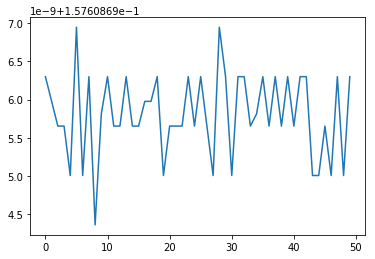

In [32]:
plt.plot(history.history['acc'])

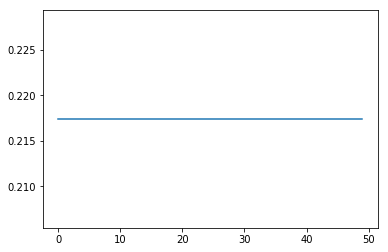

In [33]:
plt.plot(history.history['val_acc'])

#### Next steps are to add additional data with this movement and make the model more general possibly with additional movements and/or angles, at the moment we can achieve perfect accuracy with neural net